In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

COMMON_PATH = os.path.dirname(os.getcwd())
PATH =  os.path.join(COMMON_PATH, r'data\train_datasets')

# Reading files

This notebook contains simple stacking on 50% of test data. It uses outputs from MTGNN, Linear Regression on compressed data and ARIMA. 

In [23]:
ticker_names = [name[:-4] for name in os.listdir(os.path.join(COMMON_PATH, r'data\fintech'))]

fintech_train = pd.read_csv(os.path.join(PATH, 'fintech_train.csv'))
fintech_test = pd.read_csv(os.path.join(PATH, 'fintech_test.csv'))
fintech_train['date'] = pd.to_datetime(fintech_train['date'])
fintech_test['date'] = pd.to_datetime(fintech_test['date'])

validation_size = len(fintech_test)//2
fintech_validation, fintech_final_test = fintech_test.iloc[:validation_size, :], fintech_test.iloc[validation_size:, :]

existing_tickets = [col[6:] for col in fintech_train.columns if 'close' in col]
ticker_names = list(set(ticker_names).intersection(set(existing_tickets)))

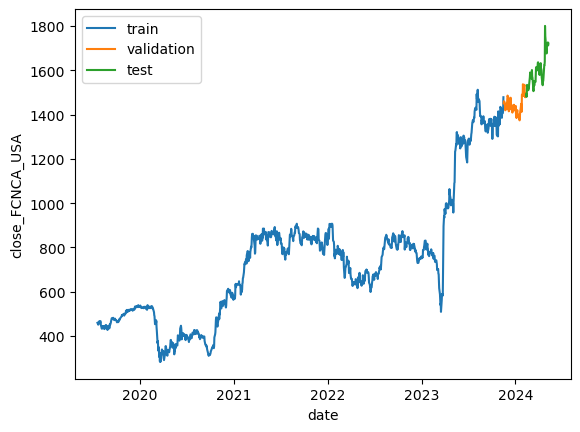

In [11]:
ticker = 'FCNCA_USA'
sns.lineplot(fintech_train, x = 'date', y = f'close_{ticker}', label = 'train')
sns.lineplot(fintech_validation, x= 'date', y = f'close_{ticker}', label = 'validation')
sns.lineplot(fintech_final_test, x= 'date', y = f'close_{ticker}', label = 'test')

plt.legend();

In [45]:
predictions_mtgnn = np.load('predictions_MTGNN.npy')[6:, 80]
predictions_arima = np.load('predictions_arima.npy')
predictions_linear = np.load('predictions_Linear.npy')

# Simple stacking

MSE: 2245.2058951941194
MAPE: 0.02501762492524261


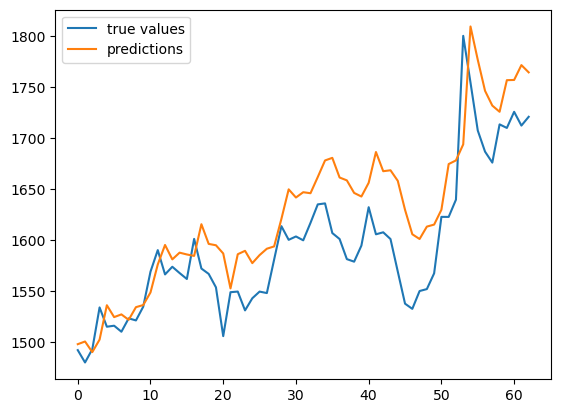

In [60]:
# it's not final solution and will be tuned later
X = np.vstack([predictions_mtgnn, predictions_arima, predictions_linear]).T
x_train, x_test = X[:validation_size, :], X[validation_size:,:]
y_train, y_test = fintech_validation[f'close_{ticker}'], fintech_final_test[f'close_{ticker}']

reg = LinearRegression().fit(x_train, y_train)

predictions = reg.predict(x_test)
plt.plot(np.array(y_test), label = 'true values')
plt.plot(np.array(predictions), label = 'predictions')
plt.legend()
print('MSE:', mean_squared_error(y_test, predictions))
print('MAPE:', mean_absolute_percentage_error(y_test, predictions))